In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time
from mpl_toolkits.mplot3d import Axes3D
import pickle

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [2]:
df_eddies = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")
df_eddies


,Day,ID,Cyc,Lon,Lat,ic,jc,x0,y0,q11,q12,q22,w,Age,fname
0,1462,1,CE,161.093546,-29.714998,261,275,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1463,1,CE,160.871720,-29.764770,258,273,910.409810,1346.368459,-0.006279,0.001039,-0.002655,-0.017868,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1464,1,CE,160.922307,-29.791470,259,272,915.918179,1345.231552,-0.003853,0.000654,-0.002549,-0.012804,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1465,1,CE,160.955011,-29.644446,259,276,914.513286,1361.918280,-0.004816,0.001225,-0.003001,-0.015635,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1466,1,CE,160.900960,-29.634113,258,276,909.171353,1361.201101,-0.003874,0.001326,-0.003299,-0.014347,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132634,10646,2962,CE,155.090978,-40.102161,223,14,708.322310,67.634123,-0.002455,-0.000032,-0.001645,-0.008201,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132635,10647,2962,CE,154.836115,-40.385267,220,6,695.611882,30.128608,-0.001272,0.000185,-0.001351,-0.005245,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132636,10648,2962,CE,154.979715,-40.569836,223,3,712.690769,14.777712,-0.001122,0.000260,-0.001881,-0.006006,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
132637,10649,2962,CE,155.150873,-40.263961,224,11,717.914731,52.244946,-0.001737,-0.000091,-0.001655,-0.006783,28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


Text(0, 0.5, 'y (km)')

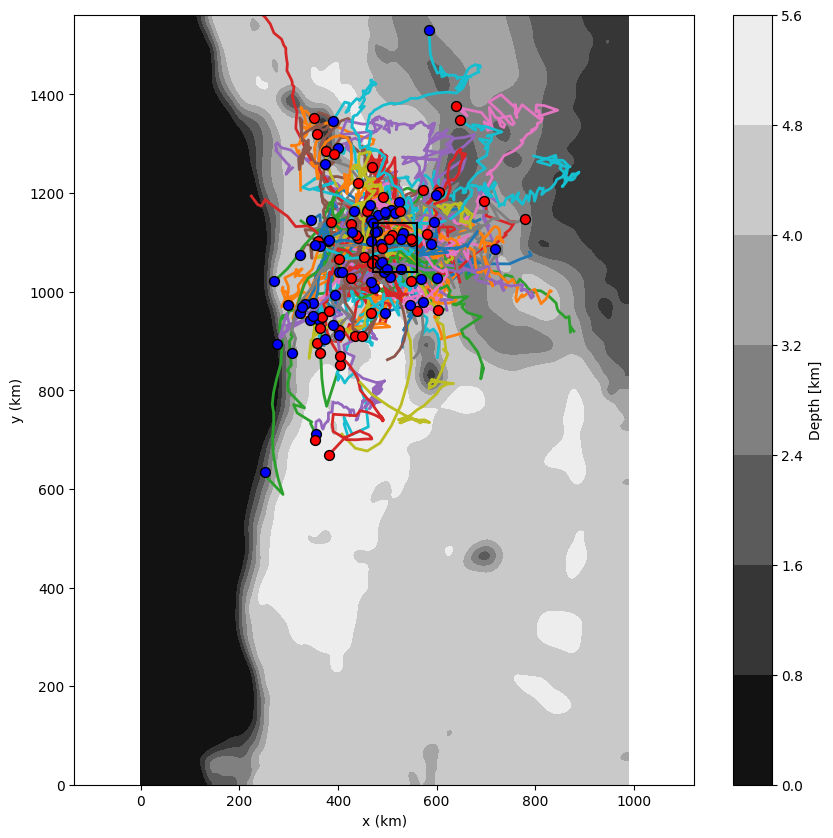

In [3]:
plt.figure(figsize=(10,10))
plt.contourf(X_grid, Y_grid, h/1000, cmap='gray')
plt.colorbar(label='Depth [km]')

x1, x2 = 470, 560
y1, y2 = 1040, 1140

df_knoll = df_eddies[(df_eddies['x0']>=x1)&(df_eddies['x0']<=x2)&
                        (df_eddies['y0']>=y1)&(df_eddies['y0']<=y2)]
for eddy in df_knoll['ID'].unique():
    df = df_eddies[df_eddies['ID']==eddy].copy()
    cyc = df.iloc[0].Cyc
    plt.plot(df['x0'], df['y0'], label=f'{cyc}{eddy}',
            linewidth=2)
    plt.scatter(df.iloc[-1]['x0'], df.iloc[-1]['y0'], edgecolors='k',
                color='r' if cyc=='AE' else 'b', zorder=10, s=50)

plt.plot([x1, x2], [y1, y1], zorder=1000, color='k')
plt.plot([x1, x2], [y2, y2], zorder=1000, color='k')
plt.plot([x1, x1], [y1, y2], zorder=1000, color='k')
plt.plot([x2, x2], [y1, y2], zorder=1000, color='k')

plt.axis('equal')
plt.xlabel('x (km)')
plt.ylabel('y (km)')





In [4]:
df_knoll['ID'].unique()


array([  19,   30,   52,   61,   64,   88,  139,  164,  173,  226,  259,
        332,  372,  407,  429,  442,  473,  490,  499,  578,  620,  638,
        692,  698,  704,  736,  758,  762,  784,  791,  850,  871,  878,
        921,  930, 1014, 1104, 1115, 1124, 1144, 1148, 1190, 1201, 1217,
       1242, 1273, 1308, 1349, 1359, 1369, 1401, 1454, 1472, 1490, 1521,
       1580, 1597, 1625, 1638, 1687, 1694, 1699, 1749, 1771, 1777, 1797,
       1807, 1826, 1842, 1897, 1914, 1967, 1990, 1998, 2034, 2064, 2099,
       2143, 2146, 2162, 2169, 2230, 2257, 2315, 2353, 2391, 2422, 2436,
       2447, 2490, 2494, 2517, 2562, 2581, 2590, 2605, 2621, 2649, 2658,
       2665, 2678, 2707, 2716, 2737, 2748, 2769, 2848, 2882, 2908, 2932,
       2940])

In [5]:
def dopioe(ic, jc, r, u, v, X, Y):

    def find_root(x, y, degree=3):
        """Fit a degree-3 polynomial to (x, y) and return the real root closest to x's midpoint."""
        coeffs = np.polyfit(x, y, degree)
        roots = np.roots(np.poly1d(coeffs))
        real_roots = roots[np.isreal(roots)].real
        mid_x = x[len(x) // 2]
        return real_roots[np.argmin(np.abs(real_roots - mid_x))]
    
    def tangent_at_root(x, y, root_x, degree=3):
        coeffs = np.polyfit(x, y, degree)
        slope = np.polyval(np.polyder(coeffs), root_x)
        intercept = np.polyval(coeffs, root_x) - slope * root_x
        y_fit = np.polyval(coeffs, x)
        r2 = 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2) if np.sum((y - np.mean(y))**2) != 0 else 1.0
        return slope, intercept, r2

    # Vertical profile along column njc
    center_x = X[ic, jc]

    i_left = 0
    left_x = X[ic - i_left, jc]
    while center_x - left_x < r:
        i_left += 1
        if ic - i_left < 0:
            break
        
        left_x = X[ic - i_left, jc]
        
    i_right = 0
    right_x = X[ic + i_right, jc]
    while right_x - center_x < r:
        i_right += 1
        if ic + i_right >= X.shape[0]:
            break

        right_x = X[ic + i_right, jc]

    u1 = u[ic - i_left: ic + i_right + 1, jc]
    v1 = v[ic - i_left: ic + i_right + 1, jc]
    x1 = X[ic - i_left: ic + i_right + 1, jc]
    y1 = Y[ic - i_left: ic + i_right + 1, jc]
        
    xx = x1 - center_x

    # Horizontal profile along row nic
    center_y = Y[ic, jc]

    j_down = 0
    down_y = Y[ic, jc - j_down]
    while center_y - down_y < r:
        j_down += 1
        if jc - j_down < 0:
            break
        
        down_y = Y[ic, jc - j_down]
        
    j_up = 0
    up_y = Y[ic, jc + j_up]
    while up_y - center_y < r:
        j_up += 1
        if jc + j_up >= X.shape[1]:
            break
        
        up_y = Y[ic, jc + j_up]

    if (jc - j_down < 0) or (jc + j_up + 1 > X.shape[1]):
        return np.nan, np.nan, np.nan, np.nan
    
    u2 = u[ic, jc - j_down: jc + j_up + 1]
    v2 = v[ic, jc - j_down: jc + j_up + 1]
    x2 = X[ic, jc - j_down: jc + j_up + 1]
    y2 = Y[ic, jc - j_down: jc + j_up + 1]

    yy = y2 - center_y

    # print(i_left, i_right, j_down, j_up)

    if np.any(np.isnan(u1)) or np.any(np.isnan(u2)):
        return np.nan, np.nan, np.nan, np.nan

    # Compute roots and tangents
    root_x = find_root(xx, v1)
    A1, A0, r2A = tangent_at_root(xx, u1, root_x)
    B1, B0, r2B = tangent_at_root(xx, v1, root_x)
    root_y = find_root(yy, u2)
    C1, C0, r2C = tangent_at_root(yy, u2, root_y)
    D1, D0, r2D = tangent_at_root(yy, v2, root_y)
    
    alpha = A0 if r2A > r2C else C0
    beta  = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    
    q11 = B1 / 2
    q22 = -C1 / 2
    q12 = -gamma / 2
    denom = C1 * B1 + gamma**2
    if denom == 0:
        raise ZeroDivisionError("Denominator is zero.")
        
    x0 = - (alpha * gamma + beta * C1) / denom
    y0 = (beta * gamma - alpha * B1) / denom
    w = 2 * (q11 + q22)

    Q = np.array([[q11, q12], [q12, q22]])

    return x0 + center_x, y0 + center_y, w, Q


In [6]:
def compute_tilt(eddy, day, X, Y, z_r, dopioe):
    # grab the single metadata row
    row = df_eddies.query("ID == @eddy and Day == @day").iloc[0]
    fname, x0, y0, w_surf = row['fname'], row['x0'], row['y0'], row['w']
    
    # load the right u/v snapshots
    fnum = fname[-8:-3]
    u = np.where(np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnum}.npy') > 1e30, np.nan, 
                 np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnum}.npy')).astype(float)
    v = np.where(np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnum}.npy') > 1e30, np.nan, 
                 np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnum}.npy')).astype(float)
    with nc.Dataset(fname) as ds:
        t = (ds.variables['ocean_time'][:] / 86400)
    t_rel = np.flatnonzero(t == day)[0]

    u_t, v_t = u[..., t_rel], v[..., t_rel]

    records = []
    x_old, y_old = x0, y0
    for k in range(u_t.shape[-1]):
        ui, vi = u_t[..., k], v_t[..., k]
        ic, jc = np.unravel_index(np.argmin(np.hypot(x_old - X, y_old - Y)), X.shape)
        x_new, y_new, w, Q = dopioe(ic, jc, 20, ui, vi, X, Y)
        if np.sign(w) != np.sign(w_surf) or np.hypot(x_old-x_new, y_old-y_new) > 50:
            break
        records.append({
            'x': x_new, 'y': y_new, 'Q': Q, 'w': w,
            'z': k, 'Depth': z_r[150, 150, k]
        })
        x_old, y_old = x_new, y_new

    df_tilt = pd.DataFrame(records)
    if not df_tilt.empty:
        df_tilt['TD']   = np.hypot(df_tilt['x'] - df_tilt.at[0,'x'],
                                   df_tilt['y'] - df_tilt.at[0,'y'])
        df_tilt['Grad'] = df_tilt['y'].diff() / df_tilt['x'].diff()

    return df_tilt


In [8]:
with open('/srv/scratch/z5297792/Chapter2/dic_knoll.pkl', 'rb') as f:
    dic_knoll = pickle.load(f)

# dic_knoll = {}
# c = 0
# for eddy in df_knoll['ID'].unique():
#     if f'Eddy{eddy}' not in list(dic_knoll.keys()):
#         # grab & sort
#         df_e = df_knoll[df_knoll['ID']==eddy].sort_values('Day').reset_index(drop=True)
        
#         # find where Day doesn't increment by 1
#         is_break = df_e['Day'].diff().ne(1)
#         # get the integer positions
#         break_pts = is_break[is_break].index.tolist()
        
#         # include start and end
#         idxs = [0] + break_pts + [len(df_e)]
        
#         dic_knoll[f'Eddy{eddy}'] = {}
#         for k in range(len(idxs)-1):
#             start, stop = idxs[k], idxs[k+1]
#             df_surf = df_e.iloc[start:stop]
#             dic_knoll[f'Eddy{eddy}'][f'Case{k}'] = {}
#             for day in df_surf['Day']:
#                 dic_knoll[f'Eddy{eddy}'][f'Case{k}'][f'Day{day}'] = compute_tilt(eddy, day, X_grid, Y_grid, z_r, dopioe)
#                 with open('/srv/scratch/z5297792/Chapter2/dic_knoll.pkl', 'wb') as f:
#                     pickle.dump(dic_knoll, f)
                
#                 # c += 1
#                 # if c / len(df_knoll) % .1 == 0:
#                 #     print(f'{100*c / len(df_knoll)} %')
#         print(eddy)


In [13]:
i1 = np.where(np.abs(x_grid-x1)==np.min(np.abs(x_grid-x1)))
i2 = np.where(np.abs(x_grid-x2)==np.min(np.abs(x_grid-x2)))

j1 = np.where(np.abs(y_grid-y1)==np.min(np.abs(y_grid-y1)))
j2 = np.where(np.abs(y_grid-y2)==np.min(np.abs(y_grid-y2)))


In [9]:
df_knoll

,Day,ID,Cyc,Lon,Lat,ic,jc,x0,y0,q11,q12,q22,w,Age,fname
1028,1503,19,CE,156.639208,-30.876839,191,220,556.138965,1088.743259,-0.011908,0.000388,-0.001540,-0.026897,61,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1029,1504,19,CE,156.618998,-30.736749,189,223,549.676802,1102.783669,-0.010650,0.000527,-0.001662,-0.024624,61,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1030,1505,19,CE,156.568703,-30.684717,188,224,543.371324,1106.592213,-0.010264,0.000448,-0.001954,-0.024435,61,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1031,1506,19,CE,156.513181,-30.653426,186,224,537.271900,1108.051587,-0.010101,0.000341,-0.002325,-0.024853,61,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1032,1507,19,CE,156.442251,-30.687905,185,223,531.948949,1102.105900,-0.010257,0.000119,-0.002446,-0.025405,61,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131829,10568,2940,CE,156.249012,-30.701934,181,222,514.803889,1094.292083,NaN,NaN,NaN,NaN,39,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
131830,10569,2940,CE,156.159332,-30.671460,179,222,505.621855,1094.545751,-0.003442,-0.003225,-0.006554,-0.019992,39,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
131831,10570,2940,CE,156.134556,-30.701845,179,221,504.381059,1090.548829,-0.004379,-0.002602,-0.006224,-0.021206,39,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
131832,10571,2940,CE,156.113722,-30.670573,178,221,501.437840,1093.142586,-0.004867,-0.001971,-0.005768,-0.021270,39,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [10]:
dic_knoll.keys()


dict_keys(['Eddy19', 'Eddy30', 'Eddy52', 'Eddy61', 'Eddy64', 'Eddy88', 'Eddy139', 'Eddy164', 'Eddy173', 'Eddy226', 'Eddy259', 'Eddy332', 'Eddy372', 'Eddy407', 'Eddy429', 'Eddy442', 'Eddy473', 'Eddy490', 'Eddy499', 'Eddy578', 'Eddy620', 'Eddy638', 'Eddy692', 'Eddy698', 'Eddy704', 'Eddy736', 'Eddy758', 'Eddy762', 'Eddy784', 'Eddy791', 'Eddy850', 'Eddy871', 'Eddy878', 'Eddy921', 'Eddy930', 'Eddy1014', 'Eddy1104', 'Eddy1115', 'Eddy1124', 'Eddy1144', 'Eddy1148', 'Eddy1190', 'Eddy1201', 'Eddy1217', 'Eddy1242', 'Eddy1273', 'Eddy1308', 'Eddy1349', 'Eddy1359', 'Eddy1369', 'Eddy1401', 'Eddy1454', 'Eddy1472', 'Eddy1490', 'Eddy1521', 'Eddy1580', 'Eddy1597', 'Eddy1625', 'Eddy1638', 'Eddy1687', 'Eddy1694', 'Eddy1699', 'Eddy1749', 'Eddy1771', 'Eddy1777', 'Eddy1797', 'Eddy1807', 'Eddy1826', 'Eddy1842', 'Eddy1897', 'Eddy1914', 'Eddy1967', 'Eddy1990', 'Eddy1998', 'Eddy2034', 'Eddy2064', 'Eddy2099', 'Eddy2143', 'Eddy2146', 'Eddy2162', 'Eddy2169', 'Eddy2230', 'Eddy2257', 'Eddy2315', 'Eddy2353', 'Eddy2391'

In [ ]:
break

In [ ]:
for eddy in dic_knoll.keys():
    eddy = int(eddy[4:])
    dic = dic_knoll[f'Eddy{eddy}']
    for case in dic.keys():
        case = int(case[4:])
        if case != 0:
            dic_case = dic[f'Case{case}']
            fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

            for day in dic_case.keys():
                df = dic_case[day]
                if len(df) > 0:
                    axs[0].plot(df['x'], -df['Depth'] / 1000, label=day)
                    axs[1].plot(df['y'], -df['Depth'] / 1000)

            axs[0].plot(x_grid[150:200], h[150:200, round(np.mean([j1, j2]))] / 1000, color='k', linewidth=2)
            axs[1].plot(y_grid[200:250], h[round(np.mean([i1, i2])), 200:250] / 1000, color='k', linewidth=2)

            axs[0].axvline(x=x_grid[round(np.mean([i1, i2]))], linestyle='--', zorder=0, color='k')
            axs[1].axvline(x=y_grid[round(np.mean([j1, j2]))], linestyle='--', zorder=0, color='k')

            axs[0].invert_yaxis()
            axs[0].set_ylabel('Depth (km)')
            axs[0].set_xlim(x_grid[150], x_grid[200])
            axs[0].set_ylim(5, 0)
            axs[1].set_xlim(y_grid[200], y_grid[250])
            axs[1].set_ylim(5, 0)
            axs[0].set_xlabel('x (km)')
            axs[1].set_xlabel('y (km)')

            cyc = df_eddies[df_eddies['ID'] == eddy].iloc[0]['Cyc']
            fig.suptitle(f'{cyc}{eddy} - Case{case}')

            n_labels = len(dic_case.keys())
            ncol = min(7, n_labels)  # wrap after 7 items per row

            fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=ncol, frameon=False)
            plt.tight_layout(rect=[0, 0.07, 1, 0.95])

            plt.savefig(f'/srv/scratch/z5297792/Chapter2/Knoll_Images/eddy_{eddy}_case_{case}.png', dpi=300, bbox_inches='tight')
            plt.close()


In [70]:
for eddy in dic_knoll.keys():
    eddy = int(eddy[4:])
    dic = dic_knoll[f'Eddy{eddy}']
    for case in dic.keys():
        case = int(case[4:])
        if case != 0:
            dic_case = dic[f'Case{case}']
            fig, axs = plt.subplots(1, 3, figsize=(13, 5))#, sharey=True)
            
            im = 182
            jm = 220
            
            ib1, ib2 = 150, 200
            jb1, jb2 = 200, 250
            
            
            axs[2].contourf(X_grid[ib1:ib2,jb1:jb2], Y_grid[ib1:ib2,jb1:jb2], h[ib1:ib2,jb1:jb2]/1000, cmap='gray', zorder=0)
            
            axs[0].plot(x_grid[ib1:ib2], h[ib1:ib2, jm] / 1000, color='k', linewidth=2, zorder=0)
            axs[1].plot(y_grid[jb1:jb2], h[im, jb1:jb2] / 1000, color='k', linewidth=2, zorder=0)
            
            for day in dic_case.keys():
                df = dic_case[day]
                if len(df) > 0:
                    if df.iloc[-1]['y'] < y_grid[jm]:
                        zorder1 = 1
                    else:
                        zorder1 = -1
                    if df.iloc[-1]['x'] > x_grid[im]:
                        zorder2 = 1
                    else:
                        zorder2 = -1
                    axs[0].plot(df['x'], -df['Depth'] / 1000, label=day, zorder=zorder1)
                    axs[1].plot(df['y'], -df['Depth'] / 1000, zorder=zorder2)
                    axs[2].plot(df['x'], df['y'])
                    axs[2].scatter(df.iloc[0]['x'], df.iloc[0]['y'], marker='.')
            axs[0].fill_between(
                x_grid[ib1:ib2],
                h[ib1:ib2, jm] / 1000,
                y2=axs[0].get_ylim()[1],  # fill down to bottom of current y-axis
                color='k',
                alpha=0.5,
                zorder=0
            )
            axs[1].fill_between(
                y_grid[jb1:jb2],
                h[im, jb1:jb2] / 1000,
                y2=axs[0].get_ylim()[1],  # fill down to bottom of current y-axis
                color='k',
                alpha=0.5,
                zorder=0
            )
            
            axs[0].axvline(x=x_grid[im], linestyle='--', zorder=0, color='k', alpha=.4, linewidth=.5)
            axs[1].axvline(x=y_grid[jm], linestyle='--', zorder=0, color='k', alpha=.4, linewidth=.5)
            
            axs[2].axvline(x=x_grid[im], linestyle='--', zorder=0, color='k', alpha=.4, linewidth=.5)
            axs[2].axhline(y=y_grid[jm], linestyle='--', zorder=0, color='k', alpha=.4, linewidth=.5)
            
            axs[0].invert_yaxis()
            axs[0].set_ylabel('Depth (km)')
            axs[0].set_xlim(x_grid[ib1], x_grid[ib2]-4)
            axs[0].set_ylim(5, 0)
            axs[1].set_xlim(y_grid[jb1], y_grid[jb2]-4)
            axs[1].set_ylim(5, 0)
            axs[0].set_xlabel('x (km)')
            axs[1].set_xlabel('y (km)')
            axs[2].axis('equal')
            axs[2].set_xlim(x_grid[ib1], x_grid[ib2])
            axs[2].set_ylim(y_grid[jb1], y_grid[jb2])
            axs[2].set_xlabel('x (km)')
            axs[2].set_ylabel('y (km)')
            
            cyc = df_eddies[df_eddies['ID'] == eddy].iloc[0]['Cyc']
            fig.suptitle(f'{cyc}{eddy} - Case{case}')
            
            n_labels = len(dic_case.keys())
            ncol = min(9, n_labels)  # wrap after 7 items per row
            
            fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=ncol, frameon=False)
            plt.tight_layout(rect=[0, 0.07, 1, 0.95])
            
            plt.savefig(f'/srv/scratch/z5297792/Chapter2/Knoll_Images/eddy_{eddy}_case_{case}.png', dpi=300, bbox_inches='tight')
            plt.close()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 